In [32]:
import pandas as pd
import numpy as np
import urllib.request
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
#Function to open and parse url

def make_soup(url):
    page = urllib.request.urlopen(url)
    soupdata = BeautifulSoup(page, "html.parser")
    return soupdata

In [3]:
#Scrape player data from basketball reference

def scraper():
    base_url = "https://www.basketball-reference.com/"
    table_url = "https://www.basketball-reference.com/leagues/NBA_2018_per_game.html"

    table_soup = make_soup(table_url)
    urls = []
    for record in table_soup.findAll("td"):
        x = record.findAll("a")
        if len(x) > 0:
            x = str(x[0]).strip('<a href=""') 
            x = x.strip('</a>') 
            urls.append(x)
    player_url = []
    player = []
    for url in urls:
        if "teams" not in url:
            y = url.split(">")
            player_url.append(y[0].strip('.html"') + "/gamelog/2018/")
            player.append(y[1])

In [4]:
#Remove duplicate players from player url/player list

def removeDuplicates():
    print(len(player_url))
    print(len(player))
    player_url_final = []
    player_final = []
    for url in player_url:
        if url not in player_url_final:
            player_url_final.append(url)
    for p in player:
        if p not in player_final:
            player_final.append(p)
    print(len(player_url_final))
    print(len(player_final))

In [5]:
#Get data from url and put in csv format

def getData():
    playerdatasaved = ""
    index = 0
    for url in player_url_final:
        soup = make_soup(base_url + url)
        X = soup.find("div", {"class":"overthrow table_container"}).find("table", {"class":"row_summable sortable stats_table"})
        for record in X.findAll("tr"):
            playerdata = ""
            for data in record.findAll("td"):
                playerdata = playerdata+","+data.text
            playerdata = playerdata + "," + player_final[index]
            playerdatasaved = playerdatasaved + "\n" + playerdata[1:]
        index += 1
#print(playerdatasaved)

In [6]:
#Write CSV file for scraped data

def writeCSV():
    header = "Rk,G,Date,Age,Team," ",Opp,Pointdiff,GS,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player"
    file = open(os.path.expanduser("Playerdata.csv"),"wb")
    file.write(bytes(header, encoding="ascii", errors="ignore"))
    file.write(bytes(playerdatasaved, encoding="ascii", errors="ignore"))

In [111]:
#Basketball Data

df = pd.read_csv("/Users/elijahwoolford/Desktop/Playerdata_final.csv")
df.head()

,Rk,Date,Age,Team,Home/Away,Opp,Pointdiff,GS,MP,FG,...,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player,Unnamed: 30
0,Alex Abrines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,10/19/17,24-079,OKC,NaN,NYK,W (+21),0,24:15:00,1,...,0.0,1.0,0.0,2.0,3.0,3.0,-1.4,23.0,Alex Abrines,NaN
2,2,10/21/17,24-081,OKC,@,UTA,L (-9),0,29:04:00,2,...,1.0,1.0,0.0,0.0,1.0,7.0,6.9,6.0,Alex Abrines,NaN
3,3,10/22/17,24-082,OKC,NaN,MIN,L (-2),0,14:20,2,...,0.0,1.0,0.0,0.0,4.0,4.0,2.8,13.0,Alex Abrines,NaN
4,4,10/25/17,24-085,OKC,NaN,IND,W (+18),0,13:26,2,...,1.0,1.0,0.0,0.0,3.0,5.0,3.8,5.0,Alex Abrines,NaN


In [112]:
#Cleaning

df = df.drop(columns=["Unnamed: 30"])
df["Date"] = df["Date"].apply(lambda x: str(x))
df["Date"] = df["Date"].replace([' Jr.'], "10/25/17")
df = df[df.Date != "nan"]
df = df[(df["GS"] != "Did Not Play") & (df["GS"] != "Inactive") & (df["GS"] != "Did Not Dress") & 
        (df["GS"] != "Not With Team") & (df["GS"] != "Player Suspended") & (df["GS"] != "nan")]
df["FG"] = df["FG"].fillna(0)
df["FG"] = df["FG"].apply(lambda x: float(x))
df["Home/Away"] = df["Home/Away"].apply(lambda x: 0 if x == "@" else 1)
df = df.reset_index()
df.head()

,index,Rk,Date,Age,Team,Home/Away,Opp,Pointdiff,GS,MP,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player
0,1,1,10/19/17,24-079,OKC,1,NYK,W (+21),0,24:15:00,...,3.0,0.0,1.0,0.0,2.0,3.0,3.0,-1.4,23.0,Alex Abrines
1,2,2,10/21/17,24-081,OKC,0,UTA,L (-9),0,29:04:00,...,4.0,1.0,1.0,0.0,0.0,1.0,7.0,6.9,6.0,Alex Abrines
2,3,3,10/22/17,24-082,OKC,1,MIN,L (-2),0,14:20,...,0.0,0.0,1.0,0.0,0.0,4.0,4.0,2.8,13.0,Alex Abrines
3,4,4,10/25/17,24-085,OKC,1,IND,W (+18),0,13:26,...,2.0,1.0,1.0,0.0,0.0,3.0,5.0,3.8,5.0,Alex Abrines
4,5,5,10/27/17,24-087,OKC,0,MIN,L (-3),0,8:27,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-1.9,9.0,Alex Abrines


In [113]:
#Change date into datetime object for sorting purposes 

def dateToObject(date):
    x = date.split("/")
    return dt.datetime.strptime(x[0]+ "/" + x[1] + "/" + "20" + x[2], "%m/%d/%Y").strftime("%Y-%m-%d")

df["Date"] = df["Date"].apply(dateToObject)


In [114]:
#Fix Pointdiff

df["Win/Loss"] = 1
df["Pointdiff"] = df["Pointdiff"].fillna("0(0")

def getWinOrLoss(pointdiff):
    pointdiff = pointdiff.strip(" ")
    x = pointdiff.split("(")
    return x[0]

def getPointDiff(pointdiff):
    pointdiff = str(pointdiff).strip(" ")
    x = pointdiff.split("(")
    return int(x[1].strip(")"))

df["Win/Loss"] = df["Pointdiff"].apply(getWinOrLoss)
df["Pointdiff"] = df["Pointdiff"].apply(getPointDiff)
df["Win/Loss"] = df["Win/Loss"].apply(lambda x: 1 if x == "W " else 0)

In [119]:
#Fix minutes

df["MP"].fillna("00:00",inplace=True)
def timeToDecimal(mp):
    if str(mp).isdigit() == False:
        x = mp.split(":")
    return round((float(x[1]) / 60) + float(x[0]), 2)


df["MP"] = df["MP"].apply(timeToDecimal)

In [120]:
df.head()

,index,Rk,Date,Age,Team,Home/Away,Opp,Pointdiff,GS,MP,...,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player,Win/Loss
0,1,1,2017-10-19,24-079,OKC,1,NYK,21,0,24.25,...,0.0,1.0,0.0,2.0,3.0,3.0,-1.4,23.0,Alex Abrines,1
1,2,2,2017-10-21,24-081,OKC,0,UTA,-9,0,29.07,...,1.0,1.0,0.0,0.0,1.0,7.0,6.9,6.0,Alex Abrines,0
2,3,3,2017-10-22,24-082,OKC,1,MIN,-2,0,14.33,...,0.0,1.0,0.0,0.0,4.0,4.0,2.8,13.0,Alex Abrines,0
3,4,4,2017-10-25,24-085,OKC,1,IND,18,0,13.43,...,1.0,1.0,0.0,0.0,3.0,5.0,3.8,5.0,Alex Abrines,1
4,5,5,2017-10-27,24-087,OKC,0,MIN,-3,0,8.45,...,0.0,0.0,0.0,0.0,3.0,0.0,-1.9,9.0,Alex Abrines,0


In [43]:
#Draftkings NBA Scoring System

#Point +1 Pt
#Made 3pt Shot +0.5 Pts
#Rebound +1.25 Pts
#Assist +1.5 Pts
#Steal +2 Pts
#Block +2 Pts
#Turnover -0.5 pts
#Double-Double {Max 1 Per Player: Points, Rebounds, Assists, Blocks, Steals} +1.5 Pts
#Triple-Double {Max 1 Per Player: Points, Rebounds, Assists, Blocks, Steals} +3 Pts

In [121]:
#DK Points
df["DK_Score"] = (((df["PTS"]*1) + (df["3P"]*0.5) + (df["TRB"]*1.25) + (df["AST"]*1.5) + 
                             (df["STL"]*2) + (df["BLK"]*2)) - (df["TOV"]*0.5))

In [122]:
#DK Bonus

for index, row in df.iterrows():
    counter = 0
    if row["PTS"] >= 10:
        counter += 1
    if row["TRB"] >= 10:
        counter += 1
    if row["AST"] >= 10:
        counter += 1
    if row["BLK"] >= 10:
        counter += 1
    if row["STL"] >= 10:
        counter += 1
    if counter == 2:
        df["DK_Score"][index] += 1.5
    if counter >= 3:
        df["DK_Score"][index] += 3

In [123]:
df.head()

,index,Rk,Date,Age,Team,Home/Away,Opp,Pointdiff,GS,MP,...,STL,BLK,TOV,PF,PTS,GmSc,+/-,Player,Win/Loss,DK_Score
0,1,1,2017-10-19,24-079,OKC,1,NYK,21,0,24.25,...,1.0,0.0,2.0,3.0,3.0,-1.4,23.0,Alex Abrines,1,8.25
1,2,2,2017-10-21,24-081,OKC,0,UTA,-9,0,29.07,...,1.0,0.0,0.0,1.0,7.0,6.9,6.0,Alex Abrines,0,16.00
2,3,3,2017-10-22,24-082,OKC,1,MIN,-2,0,14.33,...,1.0,0.0,0.0,4.0,4.0,2.8,13.0,Alex Abrines,0,6.00
3,4,4,2017-10-25,24-085,OKC,1,IND,18,0,13.43,...,1.0,0.0,0.0,3.0,5.0,3.8,5.0,Alex Abrines,1,11.50
4,5,5,2017-10-27,24-087,OKC,0,MIN,-3,0,8.45,...,0.0,0.0,0.0,3.0,0.0,-1.9,9.0,Alex Abrines,0,0.00


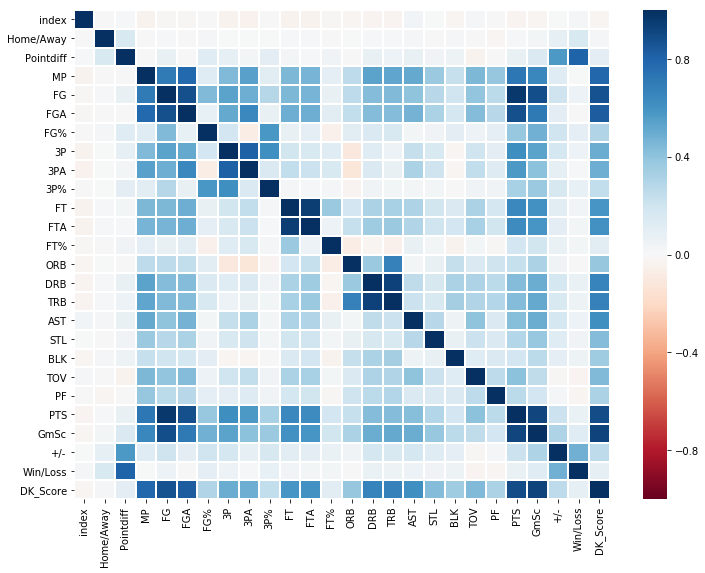

In [124]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="RdBu", ax=ax, linewidths=1)

In [125]:
#get opponets stats allowed per game

opp_team = df.groupby("Opp")
opp_team_stats = {}
y = df["Opp"].dropna()
y = y.unique()
for team in y:
    X = opp_team.get_group(team)
    for column in X:
        if X[column].dtype == "float64":
            opp_team_stats[team + "_" + column] = X[column].mean()

In [126]:
ma_player = []
p = df.groupby("Player")
z = df["Player"].dropna()

In [127]:
for player in z.unique():
    x = p.get_group(player).sort_values(by=["Date"])
    x = x.reset_index()
    x = x.drop(["level_0", "index"],1)
    count = 0
    index = 0
    date = x["Date"][0]
    while count != 5:
        try:
            if x["Date"][index] != date:
                date = x["Date"][index]
                count += 1
                index += 1
            else:
                index += 1 
        except KeyError:
            pass
            break
    for column in x:
        x["MA_Player_" + column] = pd.rolling_mean(x[column], index)
    ma_player.append(x)

In [128]:
df_final = pd.concat(ma_player)
df_final.head()

,Rk,Date,Age,Team,Home/Away,Opp,Pointdiff,GS,MP,FG,...,MA_Player_STL,MA_Player_BLK,MA_Player_TOV,MA_Player_PF,MA_Player_PTS,MA_Player_GmSc,MA_Player_+/-,MA_Player_Player,MA_Player_Win/Loss,MA_Player_DK_Score
0,1,2017-10-19,24-079,OKC,1,NYK,21,0,24.25,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alex Abrines,NaN,NaN
1,2,2017-10-21,24-081,OKC,0,UTA,-9,0,29.07,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alex Abrines,NaN,NaN
2,3,2017-10-22,24-082,OKC,1,MIN,-2,0,14.33,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alex Abrines,NaN,NaN
3,4,2017-10-25,24-085,OKC,1,IND,18,0,13.43,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alex Abrines,NaN,NaN
4,5,2017-10-27,24-087,OKC,0,MIN,-3,0,8.45,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alex Abrines,NaN,NaN


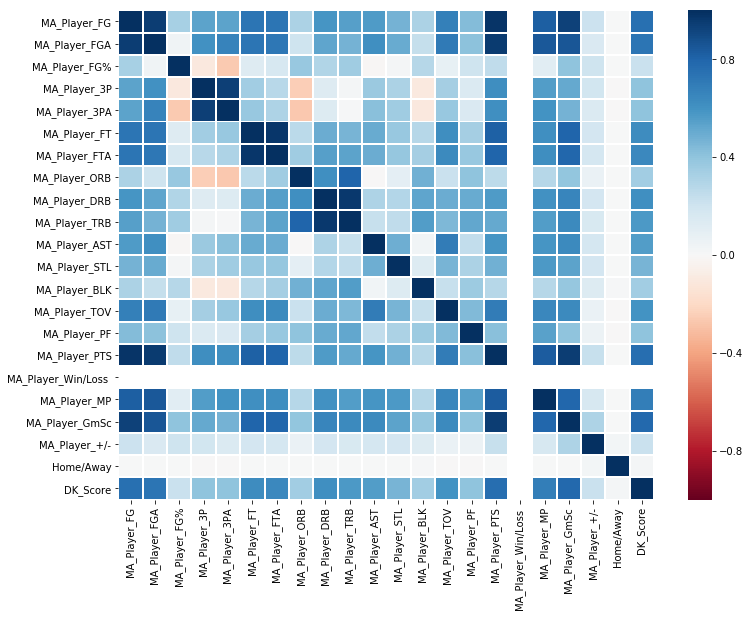

In [130]:
Y = df_final.loc[:, ["MA_Player_FG", "MA_Player_FGA", "MA_Player_FG%", "MA_Player_3P", "MA_Player_3PA", 
                     "MA_Player_FT", "MA_Player_FTA", "MA_Player_ORB", "MA_Player_DRB", 
                     "MA_Player_TRB", "MA_Player_AST", "MA_Player_STL", "MA_Player_BLK", "MA_Player_TOV", 
                     "MA_Player_PF", "MA_Player_PTS", "MA_Player_Win/Loss ", "MA_Player_MP", "MA_Player_GmSc", 
                     "MA_Player_+/-", "Home/Away", "DK_Score"]]

fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(Y.corr(), vmin=-1, vmax=1, cmap="RdBu", ax=ax, linewidths=1)

In [129]:
x = df_final.isnull().sum()
x[x>0]

FG%                     1149
3P%                     7149
FT%                    11463
+/-                        5
MA_Player_Rk            2527
MA_Player_Home/Away     2527
MA_Player_Pointdiff     2527
MA_Player_GS            2527
MA_Player_MP            2527
MA_Player_FG            2527
MA_Player_FGA           2527
MA_Player_FG%           5809
MA_Player_3P            2527
MA_Player_3PA           2527
MA_Player_3P%          14068
MA_Player_FT            2527
MA_Player_FTA           2527
MA_Player_FT%          22710
MA_Player_ORB           2527
MA_Player_DRB           2527
MA_Player_TRB           2527
MA_Player_AST           2527
MA_Player_STL           2527
MA_Player_BLK           2527
MA_Player_TOV           2527
MA_Player_PF            2527
MA_Player_PTS           2527
MA_Player_GmSc          2527
MA_Player_+/-           2551
MA_Player_Win/Loss      2527
MA_Player_DK_Score      2527
dtype: int64

In [131]:
df_final.dtypes

Rk                      object
Date                    object
Age                     object
Team                    object
Home/Away                int64
Opp                     object
Pointdiff                int64
GS                      object
MP                     float64
FG                     float64
FGA                    float64
FG%                    float64
3P                     float64
3PA                    float64
3P%                    float64
FT                     float64
FTA                    float64
FT%                    float64
ORB                    float64
DRB                    float64
TRB                    float64
AST                    float64
STL                    float64
BLK                    float64
TOV                    float64
PF                     float64
PTS                    float64
GmSc                   float64
+/-                    float64
Player                  object
                        ...   
MA_Player_Age           object
MA_Playe

In [134]:
#X = df.drop(["Rk", "Age", "Team", "Date", "Opp", "Pointdiff", "GS", "MP", "Player", "DK_Score"],1)
X = df_final.loc[:, ["MA_Player_FG", "MA_Player_FGA", "MA_Player_FG%", "MA_Player_3P", "MA_Player_3PA", 
                     "MA_Player_FT", "MA_Player_FTA", "MA_Player_ORB", "MA_Player_DRB", 
                     "MA_Player_TRB", "MA_Player_AST", "MA_Player_STL", "MA_Player_BLK", "MA_Player_TOV", 
                     "MA_Player_PF", "MA_Player_PTS", "MA_Player_GmSc", "MA_Player_+/-", 
                     "MA_Player_MP", "MA_Player_Home/Away"]]
y = df_final.DK_Score

for column in X:
    X[column] = X[column].fillna(X[column].mean())

y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [135]:
y = X.isnull().sum()
y[y>0]

Series([], dtype: int64)

In [136]:
reg = linear_model.LinearRegression()
reg = reg.fit(X_train, y_train)

In [137]:
cross_val_score(reg, X_test, y_test, cv=10)

array([0.54713222, 0.59734155, 0.60200847, 0.60762156, 0.60145765,
       0.57727558, 0.57584068, 0.64072905, 0.61501582, 0.59486526])

In [138]:
regr = linear_model.Ridge(alpha=10)
regr = regr.fit(X_train, y_train)

In [139]:
cross_val_score(regr, X_test, y_test, cv=10)

array([0.5472098 , 0.59734041, 0.60138892, 0.60818722, 0.60157627,
       0.57770813, 0.57607094, 0.64046455, 0.61567429, 0.59491193])

In [140]:
regl = linear_model.Lasso(alpha=.5)
regl = regl.fit(X_train, y_train)

In [141]:
cross_val_score(regl, X_test, y_test, cv=10)

array([0.54275822, 0.59536296, 0.5955386 , 0.60234107, 0.5970793 ,
       0.5760773 , 0.57289585, 0.63683944, 0.61017866, 0.59000909])

In [142]:
rfr = RandomForestRegressor(max_depth=10, random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [143]:
cross_val_score(rfr, X_test, y_test, cv=10)

array([0.53907044, 0.58201155, 0.5732831 , 0.57487424, 0.58395778,
       0.56422385, 0.54274098, 0.61691113, 0.59935038, 0.59298525])

In [144]:
y_pred = rfr.predict(X_test)
# Mean Squared Error
print("Mean absolute error:" , mean_absolute_error(y_test, y_pred))

Mean absolute error: 6.9510033370132405


In [145]:
y_pred = reg.predict(X_test)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Mean Squared Error
print("Mean absolute error:" , mean_absolute_error(y_test, y_pred))
# Root mean squared Error
print('Root Mean Squared error: %.2f' % math.sqrt(mean_squared_error(y_test, y_pred)))

Coefficients: 
 [-5.64187277e+12  5.40816565e+12 -1.74458185e+00 -1.27574620e+12
 -2.72603139e-02 -4.36612657e+12  3.09038037e+12 -1.16810573e+13
 -8.59067688e+12  6.27289160e+12 -5.40816565e+12 -7.72595094e+12
 -5.40816565e+12  7.72595094e+12  3.09038037e+12 -6.45020474e+12
  7.72595094e+12  3.38725659e-02 -8.11612140e-02  9.49930022e-02]
Mean squared error: 78.69
Mean absolute error: 6.8039056518838406
Root Mean Squared error: 8.87


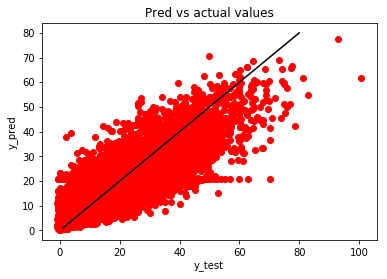

In [146]:
fig, ax = plt.subplots()
ax.scatter(x=y_test, y=y_pred, c="r")
#ax.scatter([1, 1], [, y_1], marker='^', s=150, c='r')
ax.plot([1,80],[1,80], c='black')
plt.title("Pred vs actual values")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [147]:
y_pred = regr.predict(X_test)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Mean Squared Error
print("Mean absolute error:" , mean_absolute_error(y_test, y_pred))
# Root mean squared Error
print('Root Mean Squared error: %.2f' % math.sqrt(mean_squared_error(y_test, y_pred)))

Coefficients: 
 [-0.07303008  0.6612565  -1.47606869  0.70264764 -0.01525527 -0.64479438
  0.57264414  0.14004097  0.42173614  0.56177711  0.77293194  1.14506671
  1.39137115  0.55740485  0.42616033 -0.0882069   1.08948552  0.03358364
 -0.08259459  0.10094782]
Mean squared error: 78.66
Mean absolute error: 6.800937471272061
Root Mean Squared error: 8.87


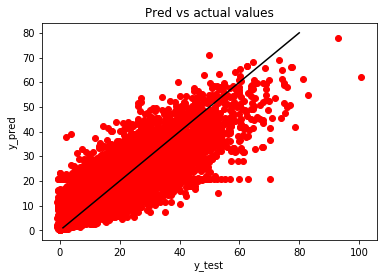

In [148]:
fig, ax = plt.subplots()
ax.scatter(x=y_test, y=y_pred, c="r")
#ax.scatter([1, 1], [, y_1], marker='^', s=150, c='r')
ax.plot([1,80],[1,80], c='black')
plt.title("Pred vs actual values")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [149]:
y_pred = regl.predict(X_test)
# The coefficients
print('Coefficients: \n', regl.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Mean Squared Error
print("Mean absolute error:" , mean_absolute_error(y_test, y_pred))
# Root mean squared Error
print('Root Mean Squared error: %.2f' % math.sqrt(mean_squared_error(y_test, y_pred)))

Coefficients: 
 [ 0.          0.57222691 -0.          0.          0.          0.
  0.          0.          0.          0.85326007  0.66534984  0.
  0.          0.          0.          0.          1.14561595  0.02048556
  0.05643897  0.        ]
Mean squared error: 79.63
Mean absolute error: 6.851828354393281
Root Mean Squared error: 8.92


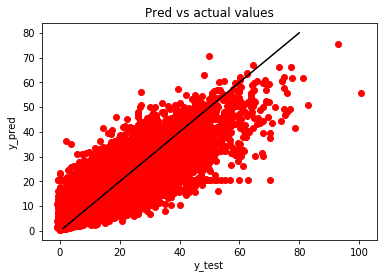

In [150]:
fig, ax = plt.subplots()
ax.scatter(x=y_test, y=y_pred, c="r")
#ax.scatter([1, 1], [, y_1], marker='^', s=150, c='r')
ax.plot([1,80],[1,80], c='black')
plt.title("Pred vs actual values")
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()